https://www.kaggle.com/c/real-estate-price-prediction-moscow

Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [14]:
#Какие навыки я хотела бы отточить на данном датасете?
#1. ООП, работа с графиками. Очень бы хотелось сделать диаграмму - картинку, колокольчик, плотность вероятности, обратн.
#и написать описание к этим функциям

#Очень бы хотелось также сделать классификацию

#В целом, хотела бы прокачать статистику, научиться строить сложные и красивые графики по функциям распределения

#Хотела бы также в двумерном пространстве сделать диаграмму, потом посчитать площадь фигуры с помощью интеграла

#Что для реализации этой задачи я сейчас буду делать:
#1. Скачаю все ноутбуки, которые мне могут пригодиться, позапускаю их, посмотрю, как они работают
#2. Минимальными усилиями сделаю задачу (без графиков) и посчитаю R2


In [4]:
#В качестве совета лектор рекомендовала взять ноутбук решивших курсовую и улучшить его
#Лучший результат на Kaggle был у Alexey Tankov по данным
#https://www.kaggle.com/competitions/realestatepriceprediction/leaderboard?
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
# ЗАГРУЗКА ДАННЫХ
folder='C:/Users/О/Desktop/ДЗ'
train_df = pd.read_csv(folder + '/train.csv')
test_df = pd.read_csv(folder + '/test.csv')
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

train_df.head(5)

Строк в трейне: 10000
Строк в тесте 5000


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [6]:
#Переводим ID и Districtid в строковый тип:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

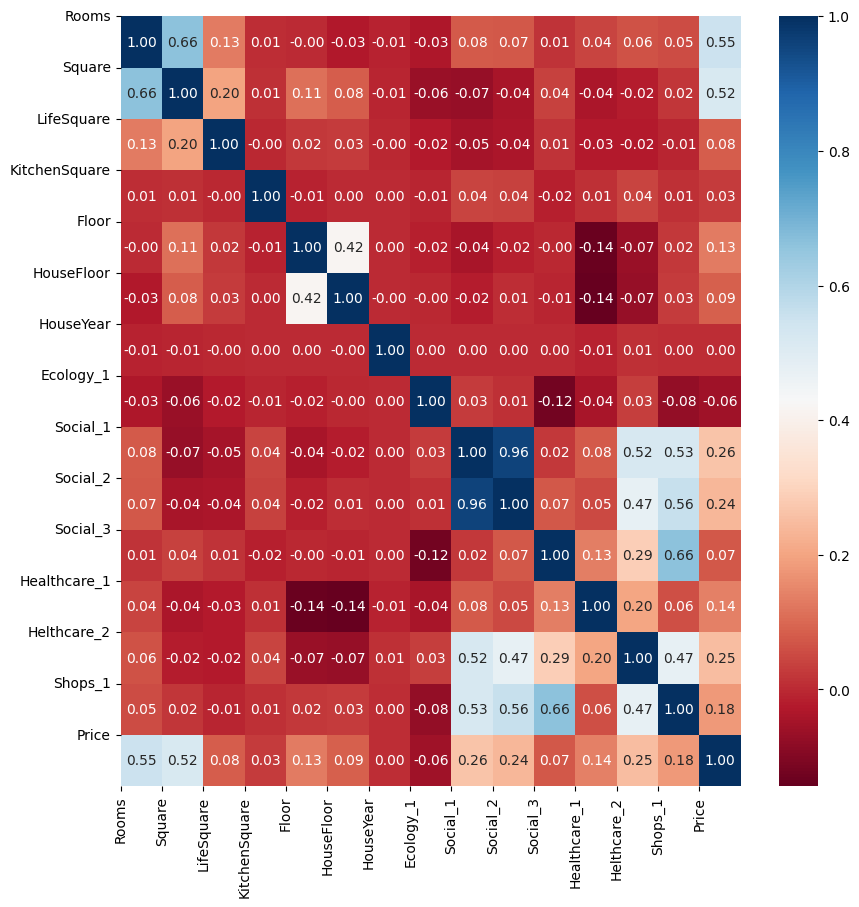

In [7]:
#Проверка на корреляцию признаков:
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [8]:
#Проверка на выбросы:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


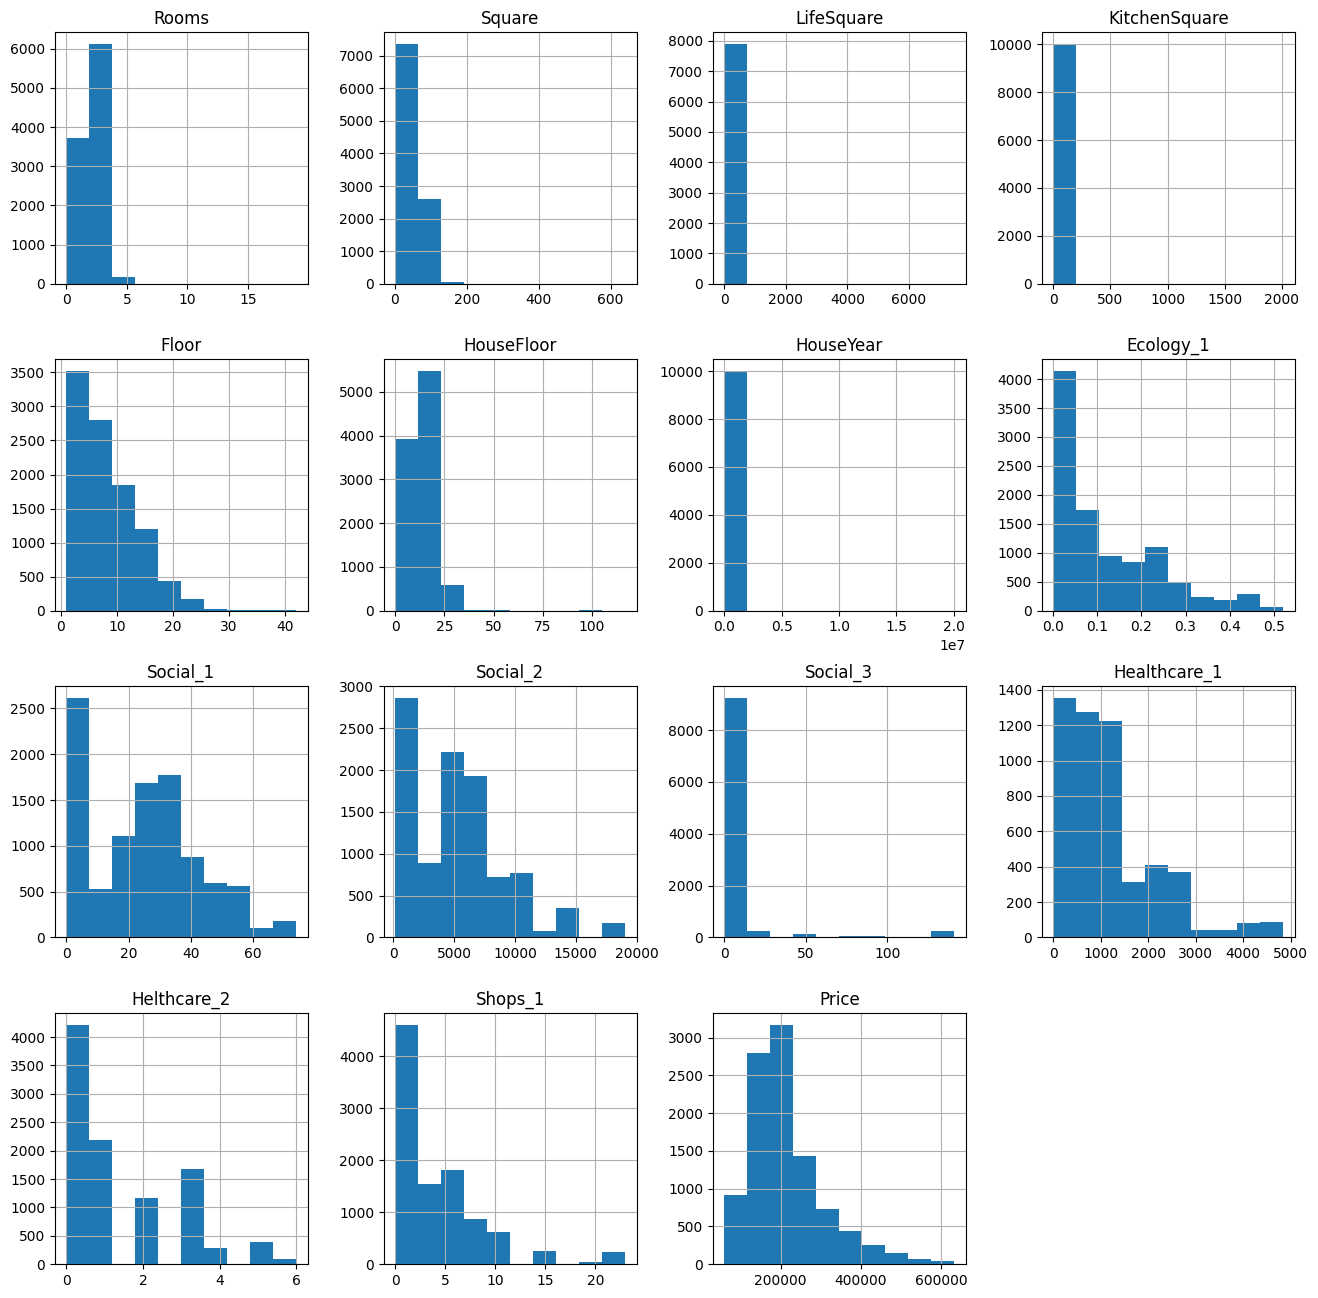

In [9]:
train_df.hist(figsize=(16,16))
plt.show()
#Выбросы наблюдаются в HouseFloor, HouseYear, KitcheSquare, LifeSquare, Social_3, Square

In [10]:
#Обработка выбросов и пропусков:¶
#Пропуски заполняются средними значениями:
# mean_LS = train_df['LifeSquare'].mean()
# train_df['LifeSquare'] = train_df['LifeSquare'].fillna(mean_LS)

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train_df.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8854,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.00000,3,23,B,207248.370520
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.00000,4,5,B,296127.115515
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B,243329.912579
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.00000,1,5,B,411691.504766
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.00000,2,3,B,179396.521035
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.00000,5,5,B,450706.552655
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.00000,2,3,B,213171.135199
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.00000,3,23,B,117647.461002
359,15722,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.00000,4,1,B,558262.139114
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,393799.531732


In [12]:
train_df.nlargest(10, 'Floor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.00000,1,5,B,411691.504766
6755,8296,146,1.0,86.386754,71.904999,0.0,37,38.0,2012,0.236108,B,B,16,3893,27,1142.90446,3,10,B,269113.584248
8357,8016,31,1.0,59.519896,24.050533,10.0,33,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,389554.063540
339,11563,8,1.0,50.390862,41.642898,0.0,32,32.0,2008,0.092291,B,B,21,4346,2,165.00000,1,2,B,97480.845791
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.00000,4,1,B,393799.531732
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.00000,3,23,B,117647.461002
561,11692,113,2.0,70.566571,70.694221,12.0,28,30.0,2014,0.050756,B,B,24,5469,1,145.00000,0,1,B,333862.631152
2597,4320,29,1.0,47.235843,21.629796,12.0,28,30.0,2015,0.069660,B,B,31,6119,4,1142.90446,1,2,B,115651.359306
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.00000,0,7,B,483283.488083
2308,1471,23,2.0,62.348477,NaN,1.0,27,25.0,1977,0.075779,B,B,6,1437,3,1142.90446,0,2,B,168381.124180


In [13]:
#Значение этажности дома более 48 - приравнивается к выбросу и заменяется средним значением по категории
train_df.loc[(train_df['HouseFloor']>48), 'HouseFloor'] = train_df['HouseFloor'].mean()
train_df.nlargest(10, 'HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2781,1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,B,B,7,1660,39,1786.0,1,5,B,411691.504766
7728,7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,B,B,50,12238,8,1970.0,2,3,B,179396.521035
3974,6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.552655
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,B,B,43,10621,1,30.0,2,3,B,213171.135199
4323,6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,B,B,22,6398,141,1046.0,3,23,B,117647.461002
359,15722,31,2.0,82.435495,48.655394,16.0,23,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,558262.139114
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
5653,8500,31,1.0,80.606246,25.299592,29.0,6,40.0,2014,0.151346,B,A,32,5889,10,830.0,4,1,B,460492.010947
8340,15270,31,2.0,81.042938,46.633001,16.0,15,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,547586.080087


In [ ]:
#Если этаж квартиры больше кол-ва этажей в доме, по такому этажу устанавливается среднее значение. 
#Аналогично поступаем и с этажностью дома - есди она ниже этажа квартиры (после изменения) - устанавливаем среднее значение.
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'Floor'] = train_df['Floor'].mean()
train_df.loc[(train_df['Floor'] > train_df['HouseFloor']), 'HouseFloor'] = train_df['HouseFloor'].mean()
train_df.nlargest(10, 'HouseYear')

In [ ]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [ ]:
#LifeSquare, KitchenSquare, Rooms, Square:
#Заменяем некорректные данные на средние значения в зависимости от кол-ва комнат:
for i in train_df['Rooms'].value_counts().index:
    b = train_df.loc[train_df['Rooms'] == i, 'LifeSquare'].mean()
    print(f'{i:.0f} - {b:.2f}')

In [ ]:
for i in train_df['Rooms'].value_counts().index:
    b = train_df.loc[train_df['Rooms'] == i, 'LifeSquare'].mean()
    print(f'{i:.0f} - {b:.2f}'

In [ ]:
#По наблюдению, с учетом жилой площади, количество жилых комнат >5 - является выбросом, т.к. площадь комнаты не может быть 
#меньше 3 квадратных метров. Жилая площадь менее 10м2 также приравнивается к выбросу и устанавливается 
#средняя площадь в зависимости от кол-ва комнат.
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Rooms'] == 1), 'LifeSquare'] = 25.16
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Rooms'] == 2), 'LifeSquare'] = 35.97
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Rooms'] == 3), 'LifeSquare'] = 54.94
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Rooms'] == 4), 'LifeSquare'] = 65.67
train_df.loc[(train_df['LifeSquare'] < 10) & (train_df['Rooms'] == 5), 'LifeSquare'] = 89.45

train_df = train_df.drop(index=[4853])

train_df.loc[train_df['Rooms'] == 10, 'Rooms'] = 2
train_df.loc[train_df['Rooms'] == 19, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] == 6, 'Rooms'] = 2

In [ ]:
train_df.nsmallest(10, 'LifeSquare')

In [ ]:
for i in train_df['Rooms'].value_counts().index:
    b = train_df.loc[train_df['Rooms'] == i, 'LifeSquare'].mean()
    print(f'{i:.0f} - {b:.2f}')

In [ ]:
#Размер кухни менее 5м2 приравнивается к 5, а для более 20м2 устанавливается медиана.
train_df[train_df['Rooms'] == 0]

In [ ]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df[train_df['Rooms'] == 0]

In [ ]:
train_df.loc[(train_df['Rooms'] > 0) & (train_df['KitchenSquare'] < 5), 'KitchenSquare'] = 5
train_df.loc[train_df['KitchenSquare'] > 20, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df['KitchenSquare'].value_counts()

In [ ]:
#Общая площадь менее 20м2 заменяется на медиану:
train_df.loc[train_df['Square'] < 20, 'Square'] = train_df['Square'].median()

In [ ]:
train_df.nlargest(10, 'Square')

In [ ]:
#3 квартиры площадью более 300м2 удаляются, т.к. не понятно, как их лучше обрабатывать. 
#С одной стороны кол-во комнат не более 2х, с другой стороны жилая площадь кореллирует с общей площадью.
train_df = train_df.drop(train_df[train_df.Square > 300].index)

plt.figure(figsize = (16, 8))

train_df['Square'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('m2')

plt.title('Square')
plt.show()


In [ ]:
train_df.nlargest(10, 'LifeSquare')

In [ ]:
#3 наибольших значения жилой площади являются выбросом. Заменяем на разность общей площади и площади кухни
train_df.loc[train_df['LifeSquare'] > 250, 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
train_df.loc[train_df.loc[:,'Id'] == '16550'][:]

In [ ]:
#Пропуски LifeSquare заменяются разностью Square и KitchenSquare.
train_df['LifeSquare'].isna().sum()

train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']

train_df['LifeSquare'].isna().sum()

In [ ]:
train_df.describe()

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.means = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медианы и среднего значения
        self.medians = X.median()
        self.means = X.mean()
    
    
    def transform(self, X):
        """Трансформация данных"""
        
        # ID и Districtid
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)
       
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = self.means['Healthcare_1']
        
        # HouseFloor, Floor
        X.loc[(X['HouseFloor'] > 48), 'HouseFloor'] = self.means['HouseFloor']
        X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = self.means['Floor']
        X.loc[(X['Floor'] > X['HouseFloor']), 'HouseFloor'] = self.means['HouseFloor']
        
        # HouseYear
        X.loc[X['HouseYear'] == 20052011, 'HouseYear'] = 2011
        X.loc[X['HouseYear'] == 4968, 'HouseYear'] = 1968
                
        # LifeSquare, KitchenSquare, Rooms, Square
        X.loc[(X['LifeSquare'] < 10) & (X['Rooms'] == 1), 'LifeSquare'] = 25.16
        X.loc[(X['LifeSquare'] < 10) & (X['Rooms'] == 2), 'LifeSquare'] = 35.97
        X.loc[(X['LifeSquare'] < 10) & (X['Rooms'] == 3), 'LifeSquare'] = 54.94
        X.loc[(X['LifeSquare'] < 10) & (X['Rooms'] == 4), 'LifeSquare'] = 65.67
        X.loc[(X['LifeSquare'] < 10) & (X['Rooms'] == 5), 'LifeSquare'] = 89.45

        X.loc[X['Rooms'] == 10, 'Rooms'] = 2
        X.loc[X['Rooms'] == 19, 'Rooms'] = 1
        X.loc[X['Rooms'] == 6, 'Rooms'] = 2
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        
        X.loc[(X['Rooms'] > 0) & (X['KitchenSquare'] < 5), 'KitchenSquare'] = 5
        X.loc[X['KitchenSquare'] > 20, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] > X['Square']), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        X.loc[X['Square'] < 20, 'Square'] = self.medians['Square']
        
        # X = X.drop(X[X.Square > 300].index)
        
        X.loc[X['LifeSquare'] > 250, 'LifeSquare'] = X['Square'] - X['KitchenSquare']
        
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['Square'] - X['KitchenSquare']
  
        X.fillna(self.medians, inplace=True)
        
        return X

In [ ]:
#Построение новых признаков
#Средняя стоимость м2 по району:
train_df["SquareMeterPrice"] = train_df["Price"] / train_df["Square"]

In [ ]:
price_by_district = train_df.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})

price_by_district.head(10)

In [ ]:
#Средняя площадь одной комнаты:
train_df['RoomSquare'] = train_df['LifeSquare'] / train_df['Rooms']
train_df.head(10)

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.price_by_district = None      
            
    def fit(self, X):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # price_by_district
        
        X['SquareMeterPrice'] = train_df['Price'] / X['Square']
        
        self.price_by_district = X.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        
        X.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'Price': 'AverageSquareMeterPrice'})
            
        self.price_by_district_median = self.price_by_district['AverageSquareMeterPrice'].median()
        
    def transform(self, X):
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # RoomSquare
        X['RoomSquare'] = X['LifeSquare'] / X['Rooms']
        
        # price_by_district
       
        X = X.merge(self.price_by_district, on=["DistrictId"], how='left')
        X.fillna(self.price_by_district_median, inplace=True)
               
        return X

In [ ]:
#Отбор признаков¶
train_df.columns.tolist()

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Shops_1', 'Helthcare_2', 'Shops_2']

new_feature_names = ['AverageSquareMeterPrice', 'RoomSquare']

target_name = 'Price'

In [ ]:
#Разбиение на train и test
train_df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')
test_df = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [ ]:
y_valid.describe()

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

In [ ]:
#Построение модели
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
#Кросс-валидация¶
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score
cv_score.mean()

In [ ]:
#Важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

In [ ]:
#Прогнозирование на тестовом датасете¶
test_df.shape
submit = pd.read_csv('/kaggle/input/realestatepriceprediction/sample_submission.csv')
submit.head()

In [ ]:
predictions = rf_model.predict(test_df)
predictions'
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('rf_submit.csv', index=False)